In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ------------------------------
# Step 1: Save Lowercase Letters a-z
# ------------------------------
def save_emnist_letters(csv_path, output_dir, split_name, img_size=(64, 64)):
    os.makedirs(output_dir, exist_ok=True)
    print(f"🔄 Converting {split_name} a-z character data...")

    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values.astype(int)
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')

    # Filter only a–z lowercase characters: labels 36–61
    letter_indices = np.where((labels >= 36) & (labels <= 61))[0]
    labels = labels[letter_indices]
    images = images[letter_indices]

    for idx, (label, image) in enumerate(tqdm(zip(labels, images), total=len(labels))):
        # Map 36–61 to a–z using ASCII
        class_char = chr(label + 61)  # chr(97) = 'a'

        label_dir = os.path.join(output_dir, split_name, class_char)
        os.makedirs(label_dir, exist_ok=True)

        # ✅ Fix EMNIST orientation
        image = np.transpose(image, (1, 0))  # Rotate -90
        
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)
        img_path = os.path.join(label_dir, f"{idx}.png")
        cv2.imwrite(img_path, image)

# ------------------------------
# Step 2: Convert Train/Test
# ------------------------------
train_csv = '/kaggle/input/emnist/emnist-byclass-train.csv'
test_csv = '/kaggle/input/emnist/emnist-byclass-test.csv'
output_base = './emnist_az_images'

save_emnist_letters(train_csv, output_base, 'train')
save_emnist_letters(test_csv, output_base, 'test')

print("✅ a–z letter images saved with correct orientation!")

🔄 Converting train a-z character data...


100%|██████████| 163939/163939 [00:27<00:00, 5996.16it/s]


🔄 Converting test a-z character data...


100%|██████████| 27059/27059 [00:04<00:00, 5993.09it/s]

✅ a–z letter images saved with correct orientation!


In [2]:
# ------------------------------
# Step 3: Split Train → Train + Val (15%)
# ------------------------------
print("🔧 Splitting train into train + val...")

train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
os.makedirs(val_dir, exist_ok=True)

for char_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, char_class)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    val_class_dir = os.path.join(val_dir, char_class)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_class_dir, img)
        os.rename(src, dst)

print("✅ Split completed. Train, Val, and Test sets created.")

🔧 Splitting train into train + val...
✅ Split completed. Train, Val, and Test sets created.


📷 Visualizing from Train Set a–z Samples...


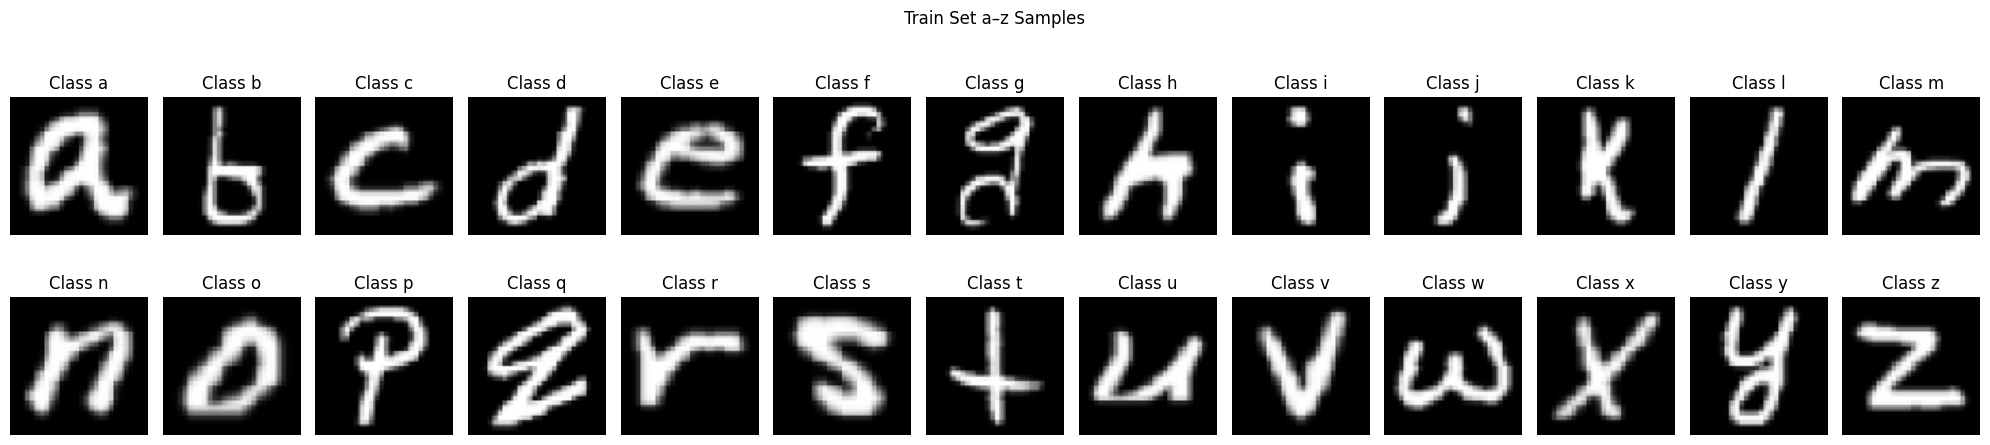

📷 Visualizing from Validation Set a–z Samples...


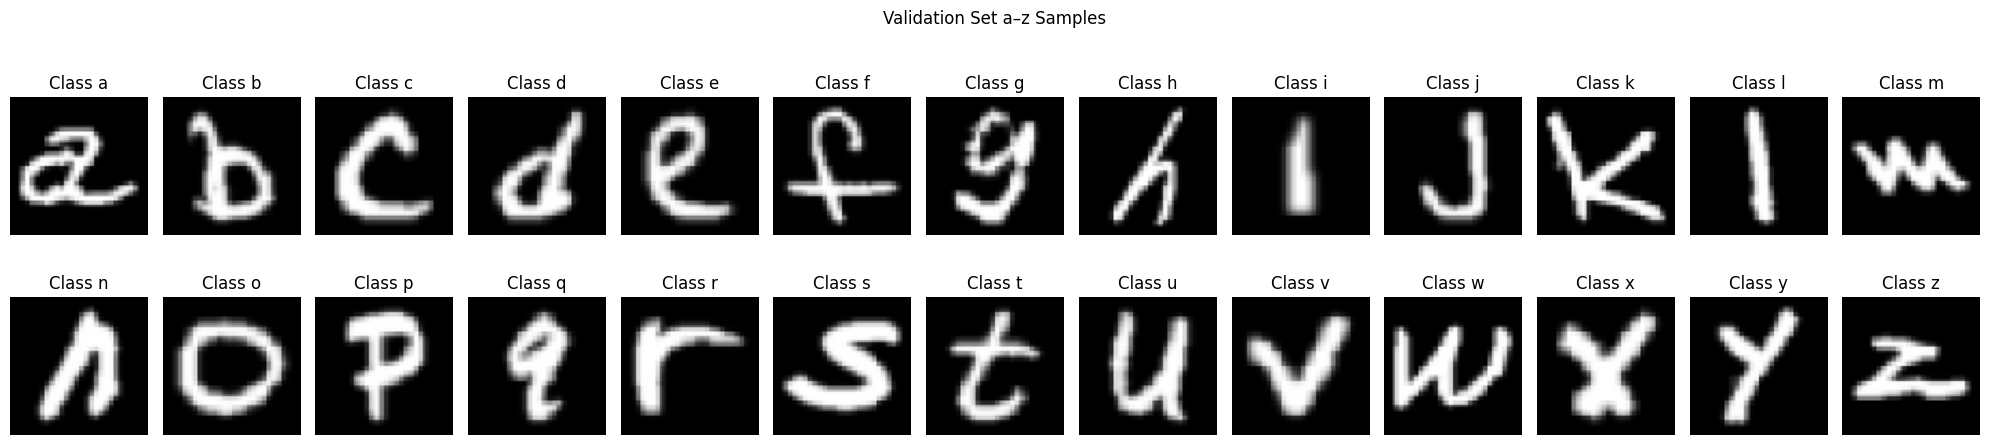

📷 Visualizing from Test Set a–z Samples...


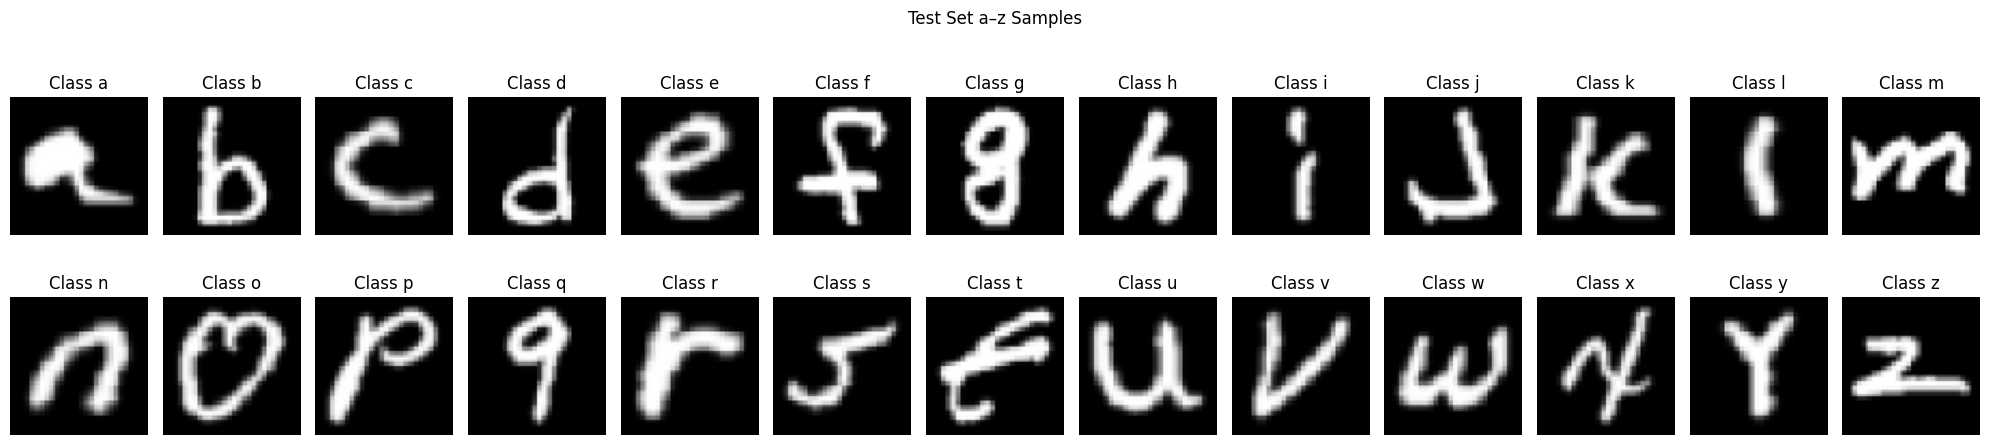

In [3]:
# ------------------------------
# Step 4: Visualize a-z Samples
# ------------------------------
def visualize_samples_from_folder(folder, title, num_classes=26):
    print(f"📷 Visualizing from {title}...")
    plt.figure(figsize=(20, 5))
    shown = 0
    for class_name in sorted(os.listdir(folder))[:num_classes]:
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        images = os.listdir(class_dir)
        if not images:
            continue
        img_path = os.path.join(class_dir, images[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(2, 13, shown + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class {class_name}")
        plt.axis('off')
        shown += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_samples_from_folder(os.path.join(output_base, 'train'), "Train Set a–z Samples")
visualize_samples_from_folder(os.path.join(output_base, 'val'), "Validation Set a–z Samples")
visualize_samples_from_folder(os.path.join(output_base, 'test'), "Test Set a–z Samples")


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------------------------------------------
# Step 2.2: Load Digit Dataset with ImageDataGenerator
# ---------------------------------------------
image_size = (64, 64)
input_shape = (64, 64, 1)
batch_size = 64
epochs = 80
num_classes = 26  # a-z letters

# Path where you saved from EMNIST
train_path = "/kaggle/working/emnist_az_images/train"
val_path   = "/kaggle/working/emnist_az_images/val"
test_path  = "/kaggle/working/emnist_az_images/test"

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',  # for numerical labels
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

2025-06-11 23:40:55.036412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749685255.233196      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749685255.288040      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 139336 images belonging to 26 classes.
Found 24603 images belonging to 26 classes.
Found 27059 images belonging to 26 classes.


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------

def build_scriptnet_enhanced(input_shape=(64, 64, 1), num_classes=26):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Block 4 - Deeper features
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Fully connected layers
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhancedV2')
    return model
print("Model initialized")

Model initialized


In [8]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet_enhanced(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749685346.645980      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749685346.646558      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNetEnhancedV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,247,962 (20.02 MB)

 Trainable params: 5,242,074 (20.00 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [9]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=12, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_EMNIST_a-z_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=80

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749685409.243798     129 service.cc:148] XLA service 0x7d2858027510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749685409.244561     129 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749685409.244585     129 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749685410.128039     129 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2178 ━━━━━━━━━━━━━━━━━━━━ 13:54:14 23s/step - accuracy: 0.0156 - loss: 4.0676

I0000 00:00:1749685423.189439     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2178/2178 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7884 - loss: 0.7516
Epoch 1: val_accuracy improved from -inf to 0.94598, saving model to scriptnet_EMNIST_a-z_best.h5
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 215s 88ms/step - accuracy: 0.7885 - loss: 0.7515 - val_accuracy: 0.9460 - val_loss: 0.1830 - learning_rate: 0.0010
Epoch 2/80
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9329 - loss: 0.2238
Epoch 2: val_accuracy improved from 0.94598 to 0.95013, saving model to scriptnet_EMNIST_a-z_best.h5
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 186s 85ms/step - accuracy: 0.9329 - loss: 0.2238 - val_accuracy: 0.9501 - val_loss: 0.1680 - learning_rate: 0.0010
Epoch 3/80
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9408 - loss: 0.1917
Epoch 3: val_accuracy improved from 0.95013 to 0.95314, saving model to scriptnet_EMNIST_a-z_best.h5
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 185s 85ms/step - accuracy: 0.9408 - loss: 0.1917 - val_accuracy: 0.9531 - val_loss: 0.1498 - learning_rate: 0.0010
Epoch 

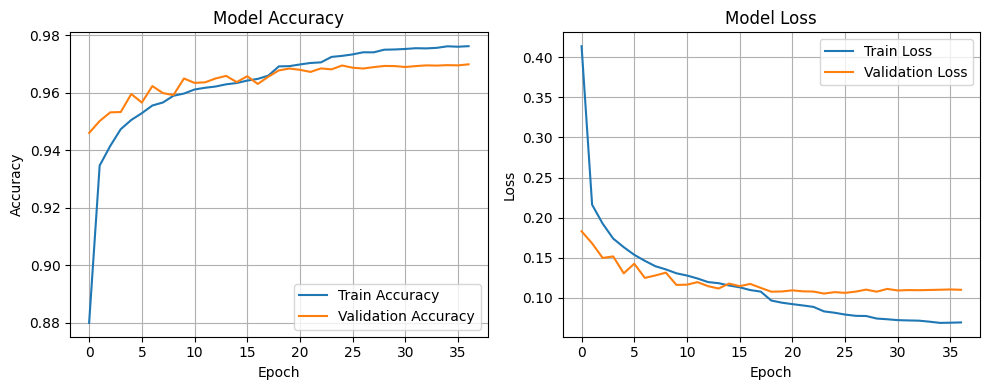

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

423/423 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step


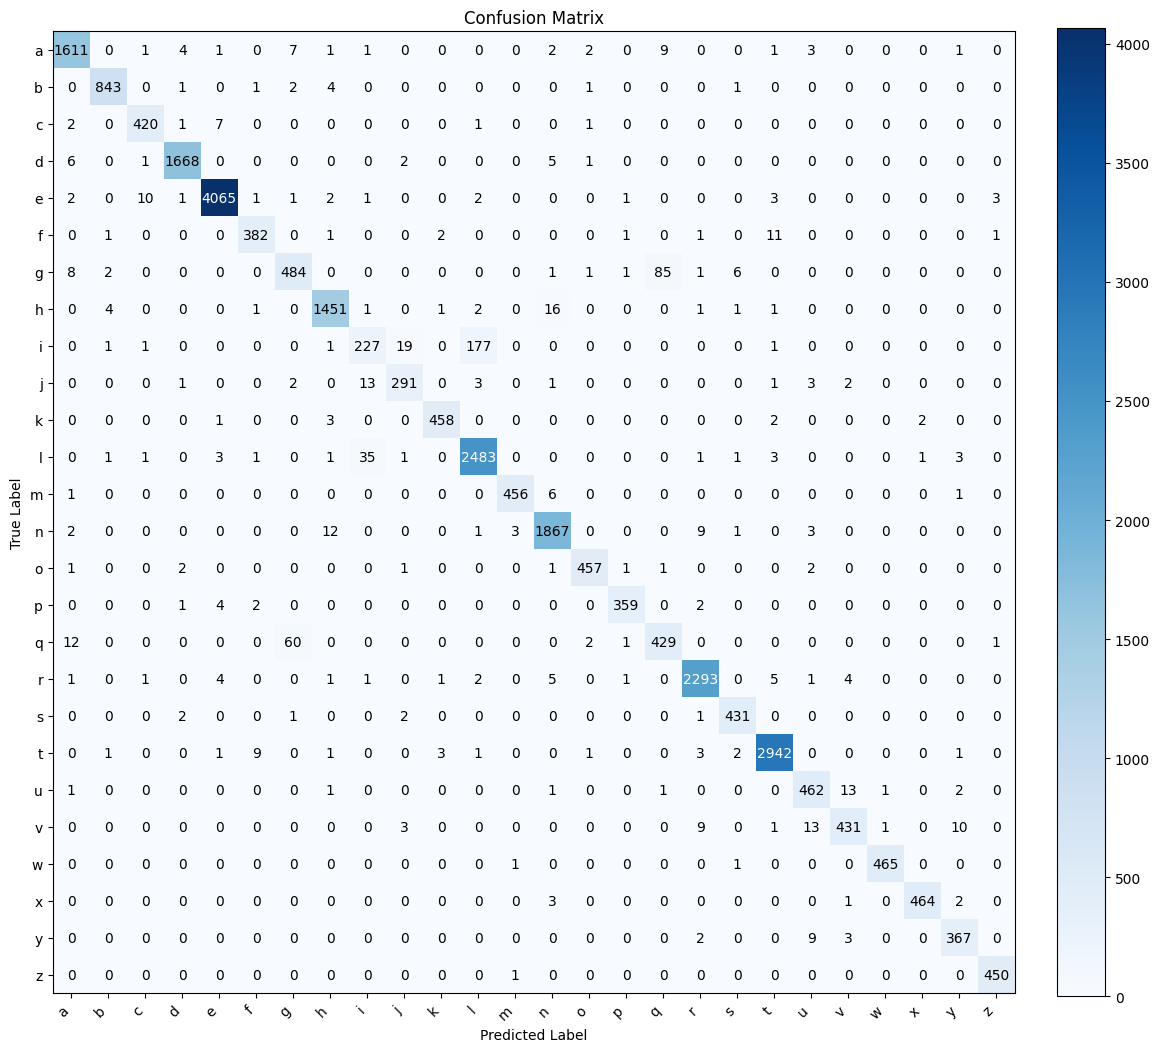

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_general(y_true, y_pred, class_labels, title="Confusion Matrix"):
    num_classes = len(class_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Dynamic figure size based on number of classes
    cell_scale = 0.45  # You can tune this for spacing
    fig_width = min(25, max(8, num_classes * cell_scale))
    fig_height = min(25, max(6, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Display matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Colorbar height matches matrix height
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)

    # Set axis labels and ticks
    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    # Adjust tick labels: auto font size and rotation
    tick_font = max(6, 12 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    # Annotate cells with counts
    fmt = 'd'
    thresh = cm.max() / 2.
    annotation_font = max(5, 12 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Example usage (in your notebook):
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix_general(y_true, y_pred, class_labels)


In [12]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

423/423 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           a     0.9781    0.9799    0.9790      1644
           b     0.9883    0.9883    0.9883       853
           c     0.9655    0.9722    0.9689       432
           d     0.9923    0.9911    0.9917      1683
           e     0.9949    0.9934    0.9941      4092
           f     0.9622    0.9550    0.9586       400
           g     0.8689    0.8217    0.8447       589
           h     0.9811    0.9811    0.9811      1479
           i     0.8136    0.5316    0.6431       427
           j     0.9122    0.9180    0.9151       317
           k     0.9849    0.9828    0.9839       466
           l     0.9293    0.9795    0.9537      2535
           m     0.9892    0.9828    0.9859       464
           n     0.9785    0.9837    0.9811      1898
           o     0.9807    0.9807    0.9807       466
           p     0.9836    0.9755    0.9795       368
           q

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(26)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")


423/423 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |    1644 |       0.9799 |            1611.0000 |       0.9986 |            1641.6713
    1 |     853 |       0.9883 |             843.0000 |       0.9996 |             852.6745
    2 |     432 |       0.9722 |             420.0000 |       0.9994 |             431.7566
    3 |    1683 |       0.9911 |            1668.0000 |       0.9995 |            1682.1378
    4 |    4092 |       0.9934 |            4065.0000 |       0.9991 |            4088.2585
    5 |     400 |       0.9550 |             382.0000 |       0.9994 |             399.7749
    6 |     589 |       0.8217 |             484.0000 |       0.9972 |             587.3756
    7 |    1479 |       0.9811 |            1451.0000 |       0.9989 |            1477.3811
    8 |     427 |       0.5316 |      

423/423 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step

📋 Classification Report:

              precision    recall  f1-score   support

           a     0.9781    0.9799    0.9790      1644
           b     0.9883    0.9883    0.9883       853
           c     0.9655    0.9722    0.9689       432
           d     0.9923    0.9911    0.9917      1683
           e     0.9949    0.9934    0.9941      4092
           f     0.9622    0.9550    0.9586       400
           g     0.8689    0.8217    0.8447       589
           h     0.9811    0.9811    0.9811      1479
           i     0.8136    0.5316    0.6431       427
           j     0.9122    0.9180    0.9151       317
           k     0.9849    0.9828    0.9839       466
           l     0.9293    0.9795    0.9537      2535
           m     0.9892    0.9828    0.9859       464
           n     0.9785    0.9837    0.9811      1898
           o     0.9807    0.9807    0.9807       466
           p     0.9836    0.9755    0.9795       368
           

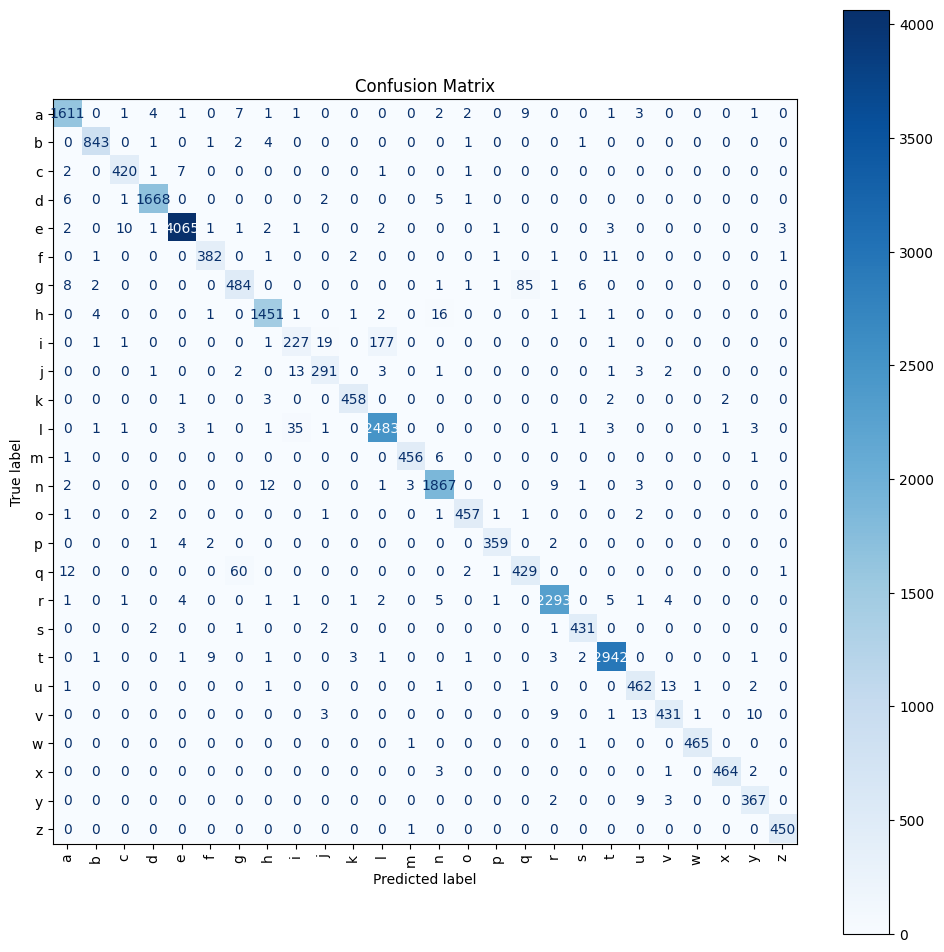


📈 ROC Curve (One-vs-Rest)


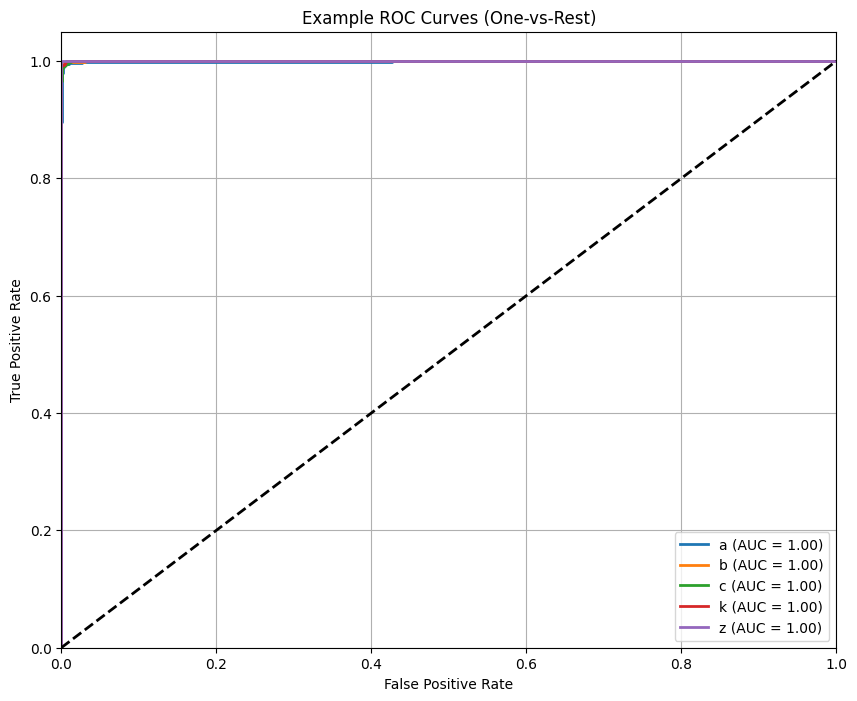

In [14]:
# Thesis Metrics and Visualization for EMNIST ByClass A-Z
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Classification Report
print("\n\U0001F4CB Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Macro & Weighted Scores
print("\n\U0001F522 Macro & Weighted Scores")
for average in ["macro", "weighted"]:
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"\n{average.capitalize()}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Per-Class Scores
print("\n\U0001F4DD Per-Class Metrics")
for i, label in enumerate(class_names):
    precision = precision_score(y_true == i, y_pred == i)
    recall = recall_score(y_true == i, y_pred == i)
    f1 = f1_score(y_true == i, y_pred == i)
    print(f"{label}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve
print("\n\U0001F4C8 ROC Curve (One-vs-Rest)")
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot a few example ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, 10))
for i, c in zip([0, 1, 2, 10, 25], colors):  # change to any class indices
    plt.plot(fpr[i], tpr[i], color=c, lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Example ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


423/423 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step
✅ Confusion matrix saved to: confusion_matrix.png


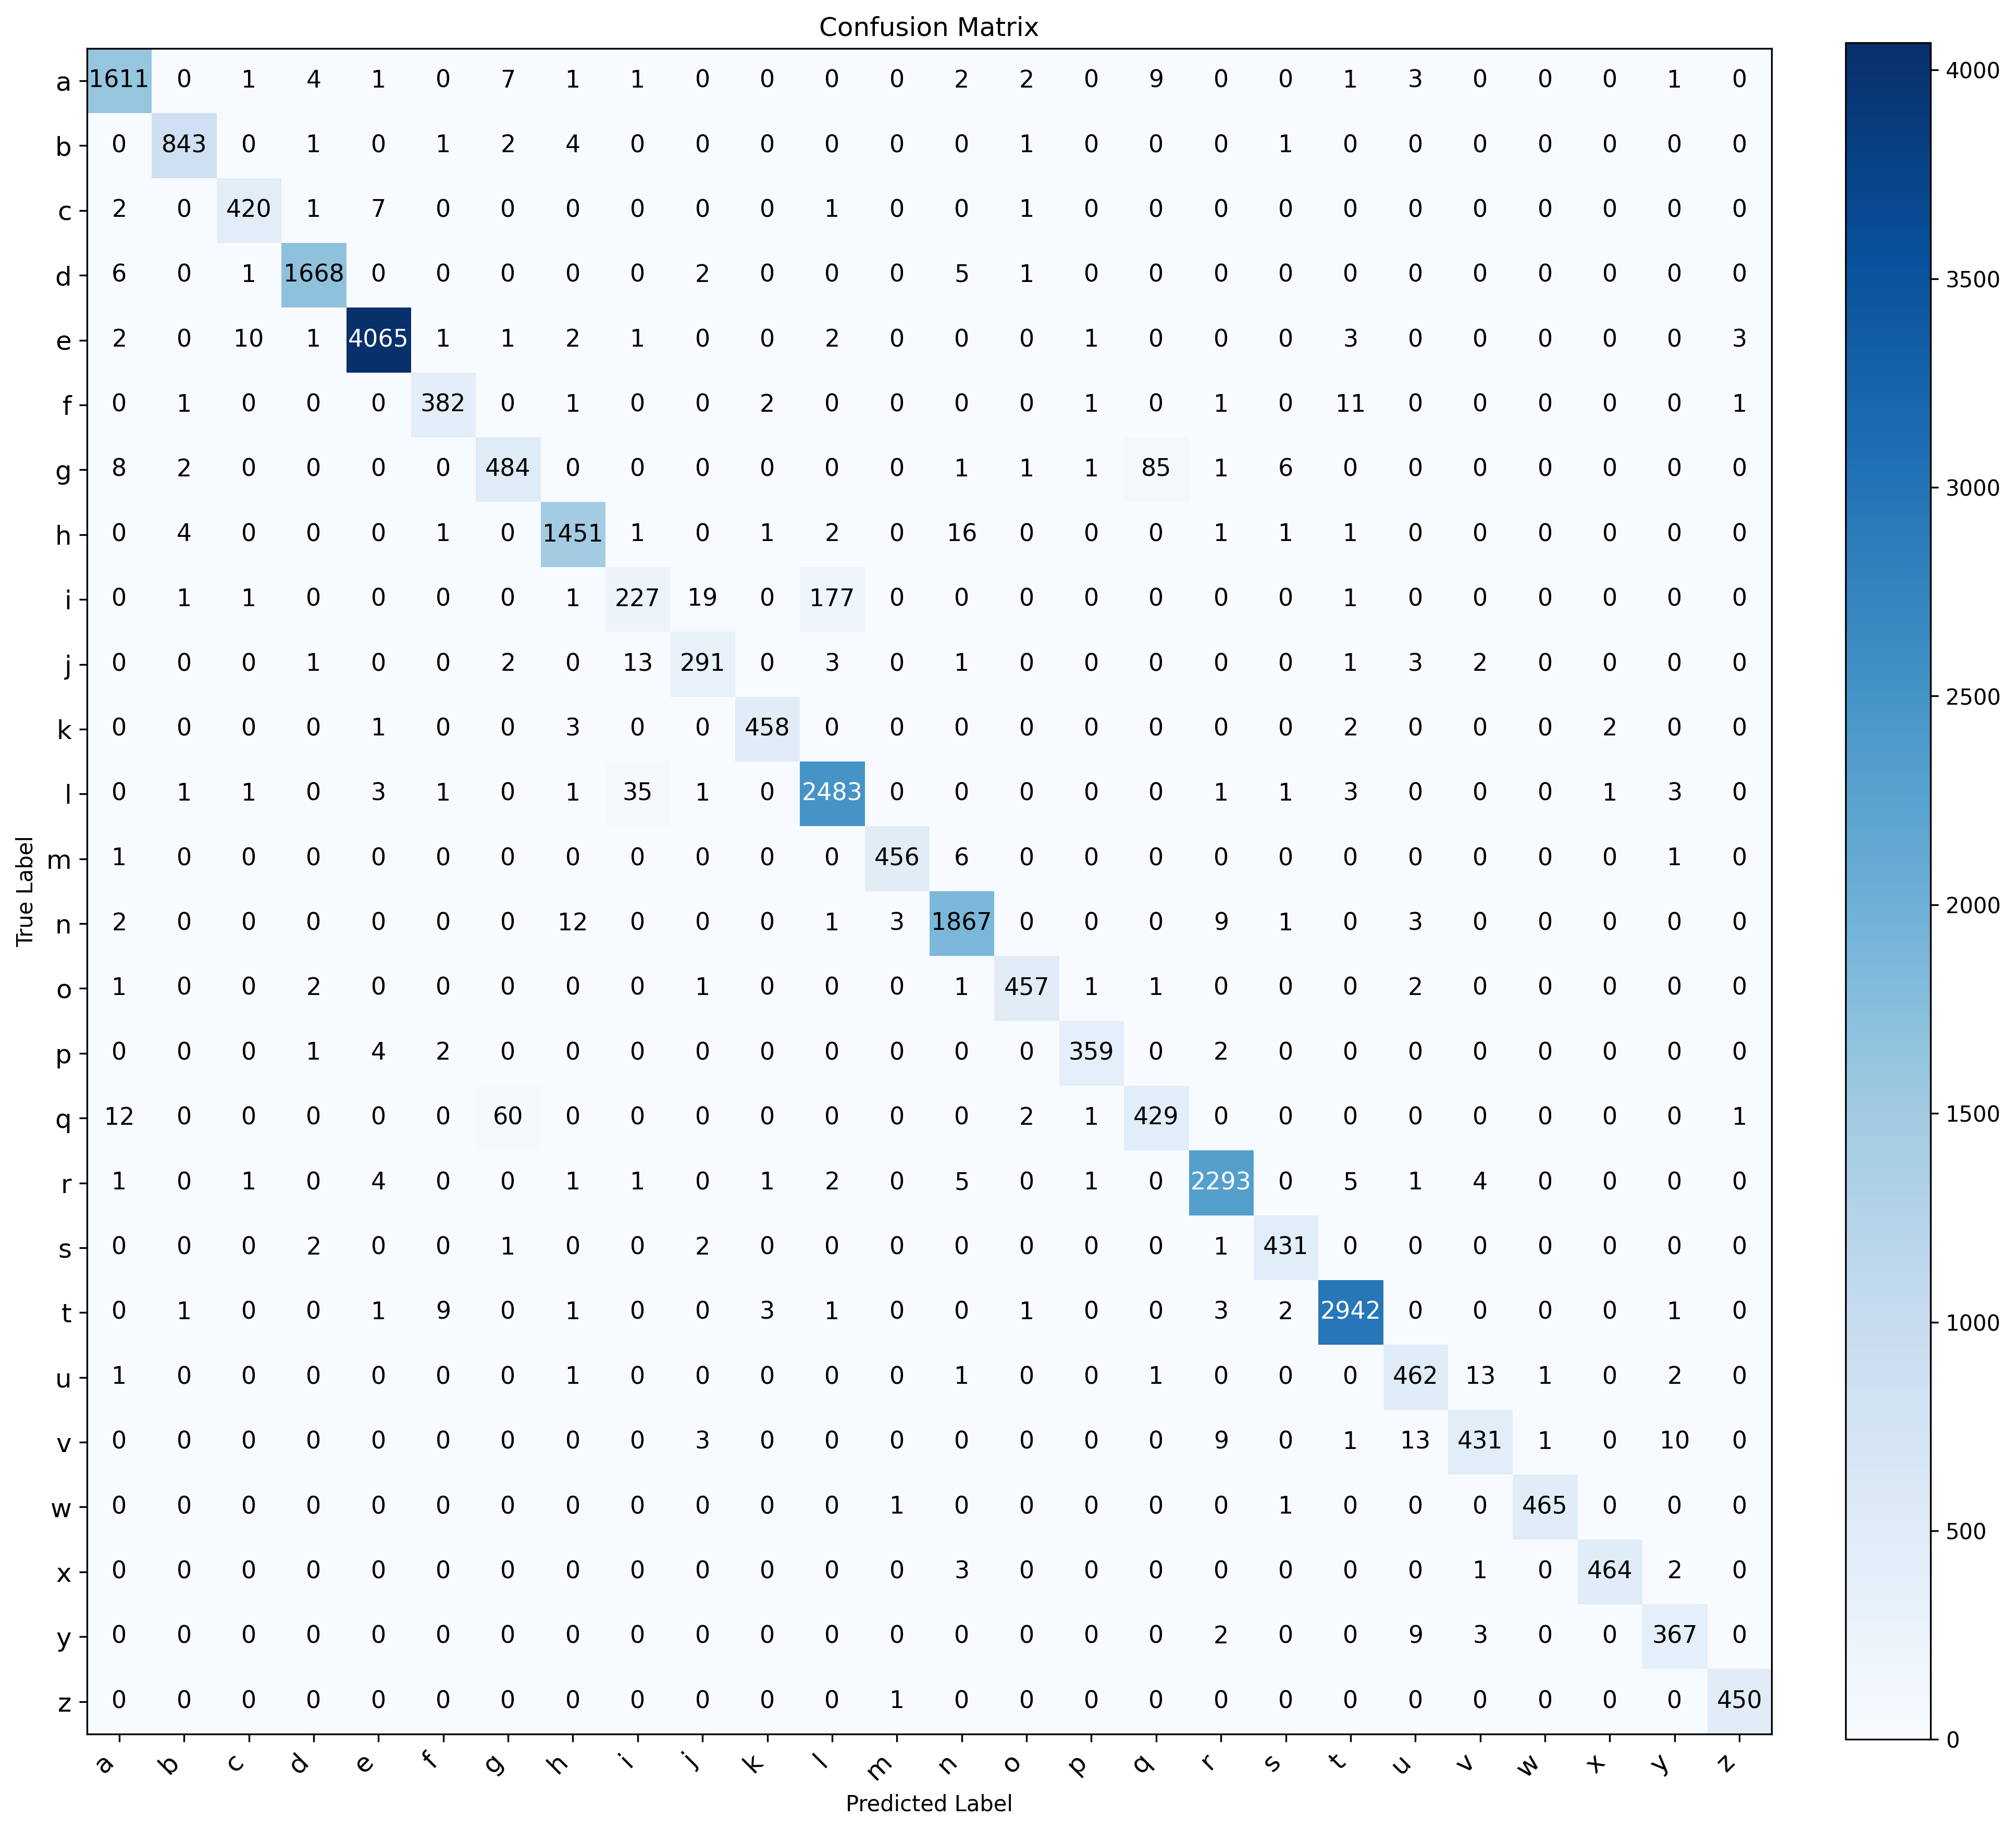

📋 Classification Report:

              precision    recall  f1-score   support

           a     0.9781    0.9799    0.9790      1644
           b     0.9883    0.9883    0.9883       853
           c     0.9655    0.9722    0.9689       432
           d     0.9923    0.9911    0.9917      1683
           e     0.9949    0.9934    0.9941      4092
           f     0.9622    0.9550    0.9586       400
           g     0.8689    0.8217    0.8447       589
           h     0.9811    0.9811    0.9811      1479
           i     0.8136    0.5316    0.6431       427
           j     0.9122    0.9180    0.9151       317
           k     0.9849    0.9828    0.9839       466
           l     0.9293    0.9795    0.9537      2535
           m     0.9892    0.9828    0.9859       464
           n     0.9785    0.9837    0.9811      1898
           o     0.9807    0.9807    0.9807       466
           p     0.9836    0.9755    0.9795       368
           q     0.8171    0.8495    0.8330       505
 

/tmp/ipykernel_35/262129706.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


✅ ROC curve plot saved to: roc_curves.png


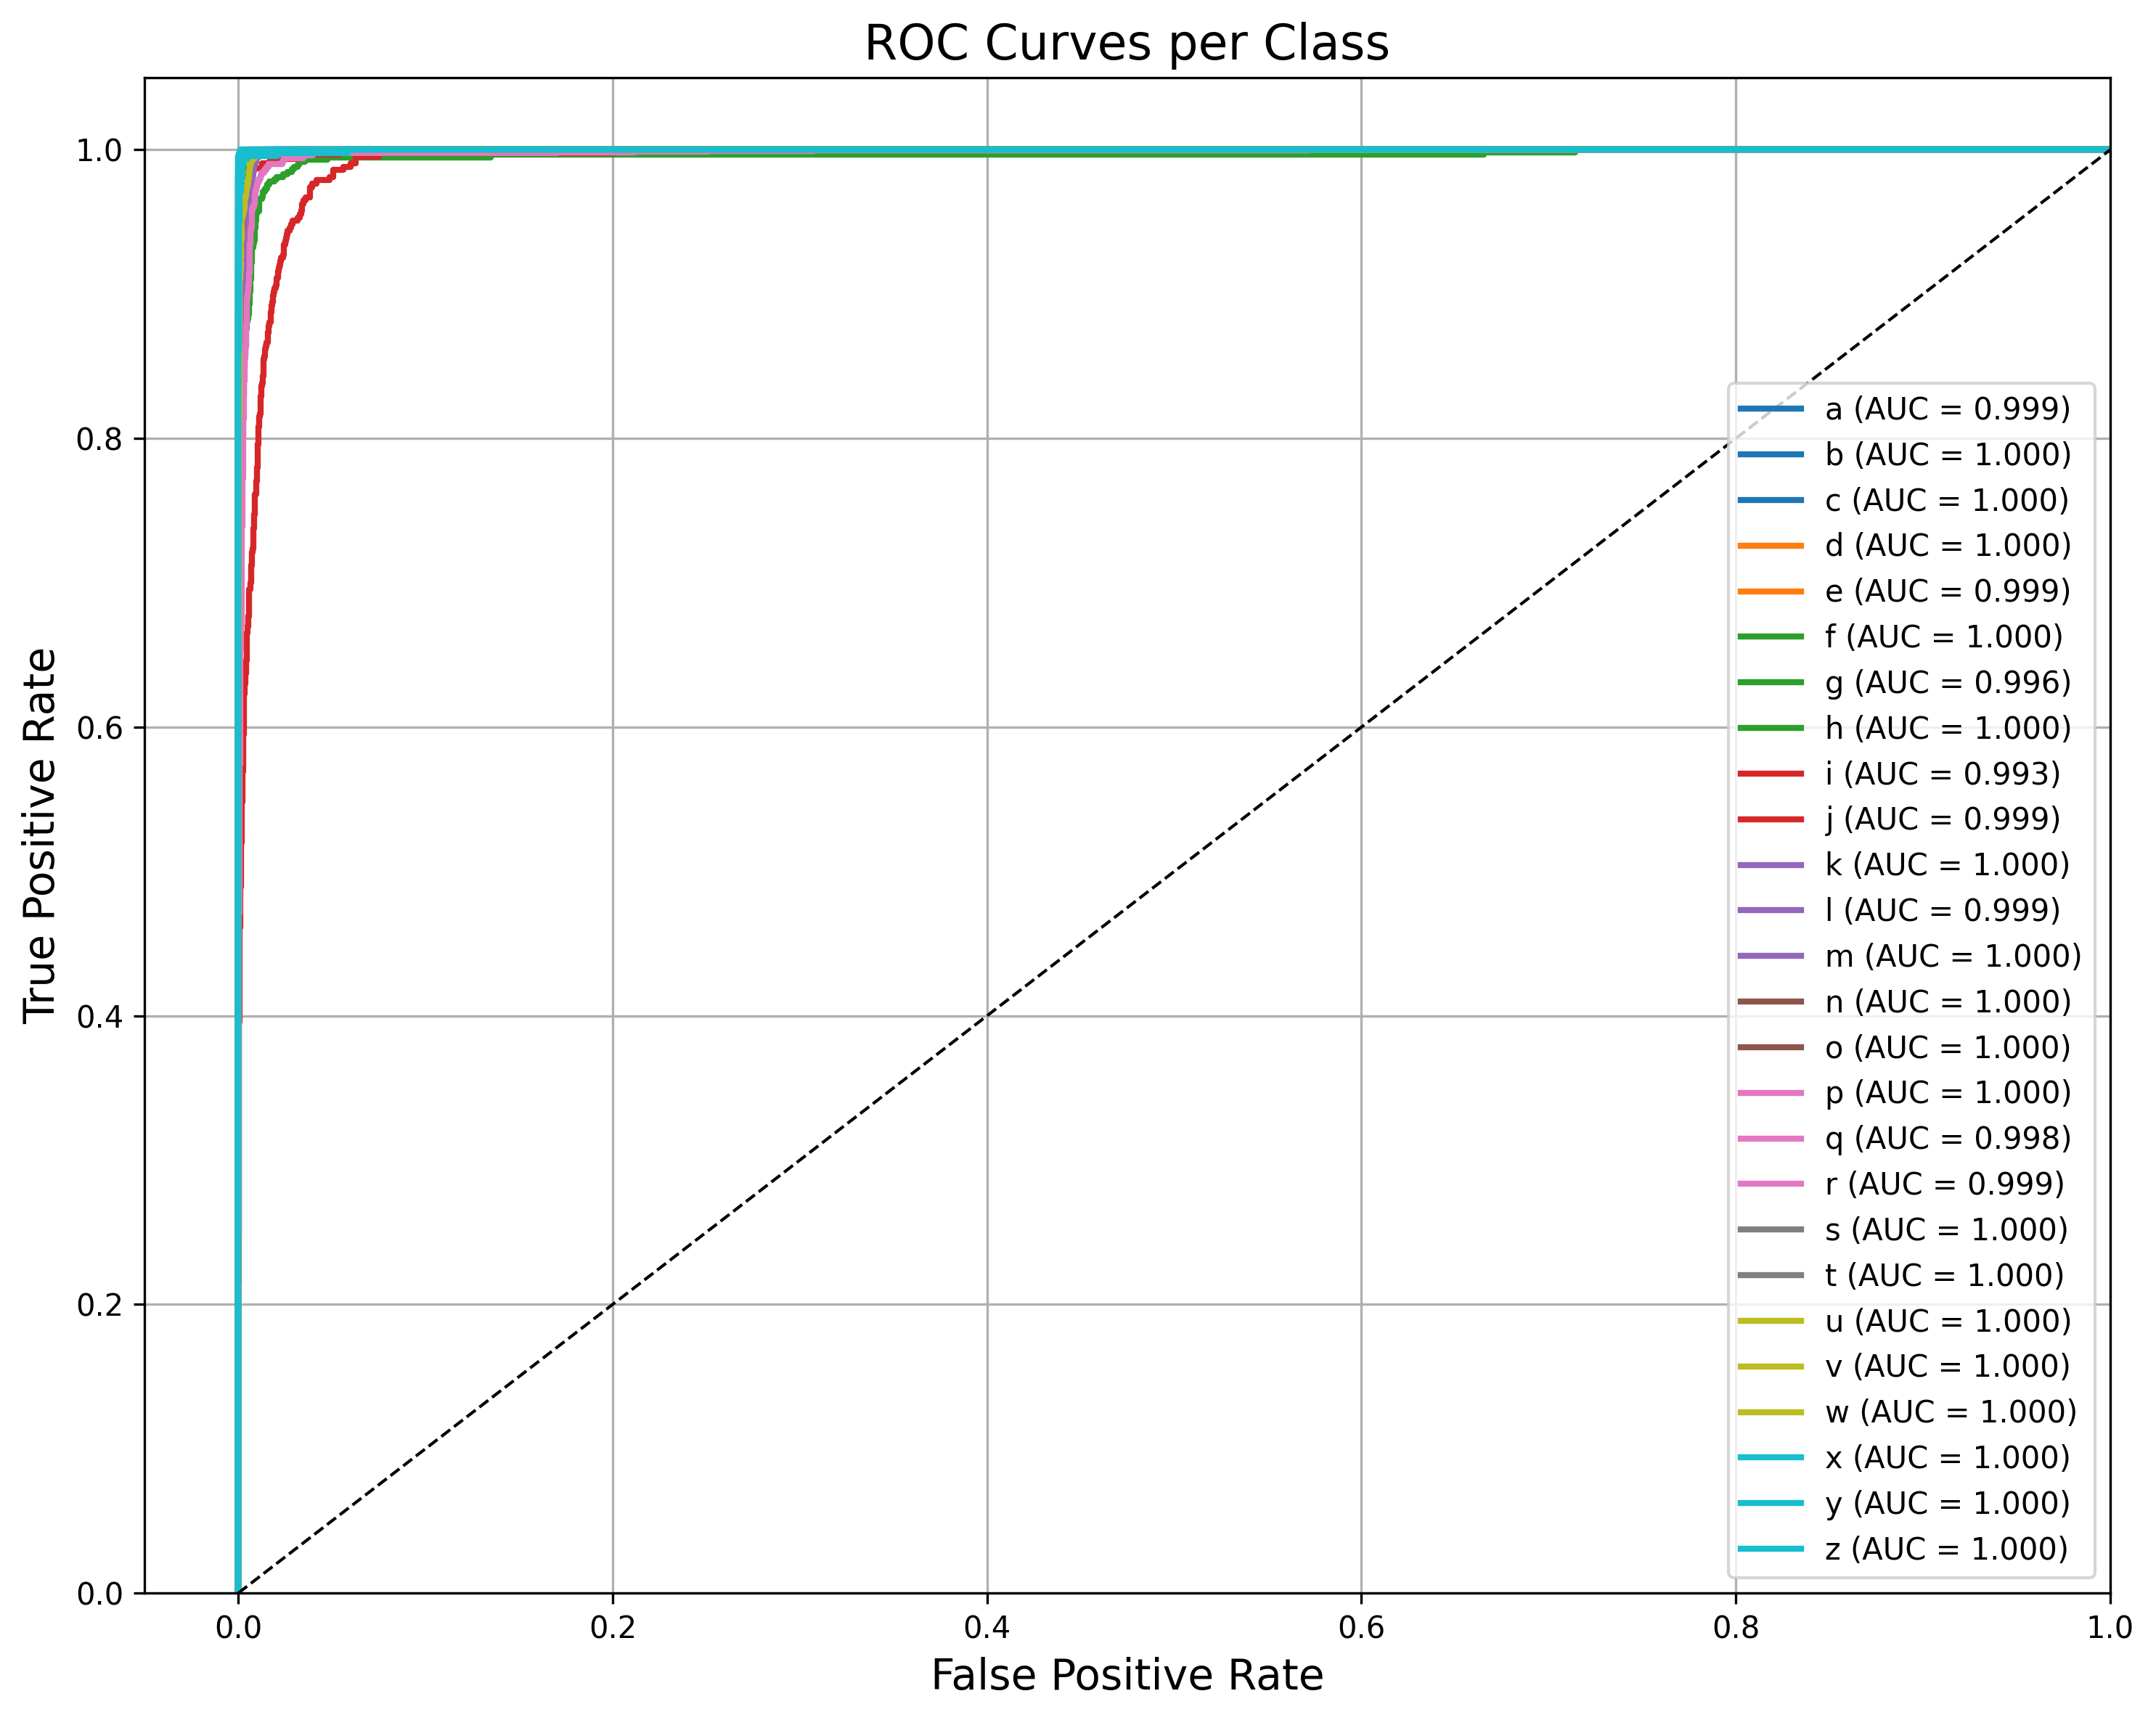

✅ Classification report metrics saved to: metrics.csv


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import pandas as pd
from sklearn.preprocessing import label_binarize

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues',
    dpi=150,       # Higher DPI for better quality
    show_grid=False  # Remove cell lines (default off)
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    if show_grid:
        ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        # Disable grid & ticks for minor
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_probs, class_names, dpi=150):
    """
    Plot ROC curves for each class (one-vs-rest).

    Parameters:
    - y_true: true labels (integer encoded)
    - y_pred_probs: predicted probabilities (num_samples x num_classes)
    - class_names: list of class names
    - dpi: figure dpi for quality
    """
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(10, 8), dpi=dpi)

    # Colors for the curves
    colors = plt.cm.get_cmap('tab10', num_classes)

    for i in range(num_classes):
        if len(np.unique(y_true_bin[:, i])) > 1:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors(i), lw=2,
                     label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
        else:
            # Class not present in true labels, skip ROC curve
            print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves per Class', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_model(
    model, test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path=None,
    export_cm_path=None,
    export_roc_path=None
):
    """
    Generalized evaluation for multi-class classifier with metrics and confusion matrix,
    ROC curve plotting, and export capabilities.

    Parameters:
    - model: keras or sklearn-like model with predict method.
    - test_generator: generator or dataset with .classes and .class_indices attributes.
    - threshold: threshold for ROC-AUC binary decisions (not used here but for reference).
    - plot_cm: bool, whether to plot confusion matrix.
    - normalize_cm: bool, normalize confusion matrix.
    - plot_roc: bool, whether to plot ROC curves.
    - export_metrics_path: str or None, path to save metrics CSV.
    - export_cm_path: str or None, path to save confusion matrix PNG.
    - export_roc_path: str or None, path to save ROC curves PNG.

    Returns:
    - metrics_df: pandas DataFrame with per-class metrics.
    """

    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    num_classes = len(class_names)

    # 1. Confusion matrix plot
    if plot_cm:
        # Setup DPI for export or display
        dpi_val = 300 if export_cm_path else 150
        num_classes = len(class_names)
        cell_scale = 0.5
        fig_width = min(25, max(10, num_classes * cell_scale))
        fig_height = min(25, max(10, num_classes * cell_scale))

        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi_val)

        cm = confusion_matrix(y_true, y_pred)
        if normalize_cm:
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            cm_norm = cm

        im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
        cbar.ax.tick_params(labelsize=10)

        ax.set(
            xticks=np.arange(num_classes),
            yticks=np.arange(num_classes),
            xticklabels=class_names,
            yticklabels=class_names,
            xlabel='Predicted Label',
            ylabel='True Label',
            title="Confusion Matrix"
        )

        tick_font = max(7, 14 - num_classes // 10)
        rotation_angle = 45 if num_classes > 10 else 0
        plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
        plt.setp(ax.get_yticklabels(), fontsize=tick_font)

        # No grid lines as requested
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

        fmt = '.2f' if normalize_cm else 'd'
        thresh = cm_norm.max() / 2.
        annotation_font = max(6, 13 - num_classes // 10)
        for i in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                val = format(cm_norm[i, j], fmt)
                ax.text(j, i, val,
                        ha="center", va="center",
                        fontsize=annotation_font,
                        color="white" if cm_norm[i, j] > thresh else "black")

        plt.tight_layout()

        if export_cm_path:
            fig.savefig(export_cm_path, dpi=dpi_val)
            print(f"✅ Confusion matrix saved to: {export_cm_path}")

        plt.show()

    # 2. Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Macro, Weighted, and Micro Precision, Recall, F1
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

    # 4. ROC Curves
    if plot_roc:
        if y_pred_probs.shape[1] == num_classes:
            dpi_val_roc = 300 if export_roc_path else 150
            plt.figure(figsize=(10, 8), dpi=dpi_val_roc)
            y_true_bin = label_binarize(y_true, classes=range(num_classes))
            colors = plt.cm.get_cmap('tab10', num_classes)
            for i in range(num_classes):
                if len(np.unique(y_true_bin[:, i])) > 1:
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, color=colors(i), lw=2,
                             label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
                else:
                    print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")
            plt.plot([0, 1], [0, 1], 'k--', lw=1)
            plt.xlim([-0.05, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=14)
            plt.ylabel('True Positive Rate', fontsize=14)
            plt.title('ROC Curves per Class', fontsize=16)
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(True)
            plt.tight_layout()
            if export_roc_path:
                plt.savefig(export_roc_path, dpi=dpi_val_roc)
                print(f"✅ ROC curve plot saved to: {export_roc_path}")
            plt.show()
        else:
            print("ROC curve plotting skipped due to mismatch in prediction probabilities dimension.")

    # 5. Export metrics dataframe if path provided
    if export_metrics_path:
        # Prepare metrics DataFrame from classification report
        metrics_df = pd.DataFrame(report).transpose()
        metrics_df.to_csv(export_metrics_path)
        print(f"✅ Classification report metrics saved to: {export_metrics_path}")

    return {
        "classification_report_dict": report,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }


results = evaluate_model(
    model,
    test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path="metrics.csv",     # Optional
    export_cm_path="confusion_matrix.png", # Optional
    export_roc_path="roc_curves.png"       # Optional
)
